# **French Motor Third-Part Liability data set**



- Claim frequency modeling, using as reference French Motor Third-Party Liability Claims (Noll, Salzmann and V. Wuthrich, 2020) and SHAP for Actuaries: Explain any Model (Mayer, Meier, and V. Wuthrich, 2023).
- Data source: CASdatasets package http://cas.uqam.ca/pub/web/CASdatasets-manual.pdf (page 62).

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import norm
import seaborn as sns

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/IBE/4th Semester/Master Thesis/Codes/Data/frenchclaim.csv")   #data(freMTPL2freq)

# **Exploratory Data Analysis**

In [ ]:
df.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1,0.10,D,5,0,55,50,B12,Regular,1217,R82
1,3.0,1,0.77,D,5,0,55,50,B12,Regular,1217,R82
2,5.0,1,0.75,B,6,2,52,50,B12,Diesel,54,R22
3,10.0,1,0.09,B,7,0,46,50,B12,Diesel,76,R72
4,11.0,1,0.84,B,7,0,46,50,B12,Diesel,76,R72


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678013 entries, 0 to 678012
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   IDpol       678013 non-null  float64
 1   ClaimNb     678013 non-null  int64  
 2   Exposure    678013 non-null  float64
 3   Area        678013 non-null  object 
 4   VehPower    678013 non-null  int64  
 5   VehAge      678013 non-null  int64  
 6   DrivAge     678013 non-null  int64  
 7   BonusMalus  678013 non-null  int64  
 8   VehBrand    678013 non-null  object 
 9   VehGas      678013 non-null  object 
 10  Density     678013 non-null  int64  
 11  Region      678013 non-null  object 
dtypes: float64(2), int64(6), object(4)
memory usage: 62.1+ MB


In [ ]:
df.describe()

,IDpol,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density
count,6.780130e+05,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000
mean,2.621857e+06,0.053247,0.528750,6.454631,7.044265,45.499122,59.761502,1792.422405
std,1.641783e+06,0.240117,0.364442,2.050906,5.666232,14.137444,15.636658,3958.646564
min,1.000000e+00,0.000000,0.002732,4.000000,0.000000,18.000000,50.000000,1.000000
25%,1.157951e+06,0.000000,0.180000,5.000000,2.000000,34.000000,50.000000,92.000000
50%,2.272152e+06,0.000000,0.490000,6.000000,6.000000,44.000000,50.000000,393.000000
75%,4.046274e+06,0.000000,0.990000,7.000000,11.000000,55.000000,64.000000,1658.000000
max,6.114330e+06,16.000000,2.010000,15.000000,100.000000,100.000000,230.000000,27000.000000


The data contains 678013  inputs to 10 variables (exclude the IDpol column which is the policy ID). Non-null values
1.   ClaimNb: Number of claims during the exposure period.
2.   Exposure: The period of exposure for a policy in years.
3.   Area: The density value of the city community where the car driver lives: from "A" for rural area to "F" for urban center.
4.   VehPower: The power of the car (ordered values).
5.   VehAge: The vehicle age, in years
6.   DrivAge: The driver's age, in years (in France, people can drive a car at 18).
7.   BonusMalus: Bonus/malus, between 50 and 350: <100 means bonus, >100 means malus in France.
8.   VehBrand: The car brand (unknown categories).
9.   VehGas: The car is gas, diesel, or regular.
10.  Density: The density of inhabitants (number of inhabitants per square kilometer) of the city where the car driver lives.
11.  Region: The policy region in France (based on the 1970-2015 classification).




**Data manipulation applied in the papers:**

*   Peeking into the Black Box (Mayer, and Lorentzen, 2020).


**Use the information about the data set from:**
*   Case Study: French Motor Third-Party Liability Claims (Noll, Salzmann, W uthrich, 2020).
*   Statistical Foundations of Actuarial Learning and its Applications (Mario V.Wüthrich and Michael Merz, 2023) - Page 561.

**Data models from papers:**
*  GLM and Neural Net = Peeking into the Black Box (Mayer, and Lorentzen, 2020), and SHAP for Actuaries: Explain any Model (Mayer, 2023).



In [ ]:
#Data Manipulation 1:
#variable group_id identifying rows that are identical except for IDpol, ClaimNb and Exposure.
#It is suspect that those identical rows are not independent.
#group_id later will be used to more honest model evaluation without leakage across training and test data sets.

# Select distinct rows, excluding specified columns
distinct = df.drop(columns=['IDpol', 'Exposure', 'ClaimNb']).drop_duplicates()

# Add a new column 'group_id' with row numbers
distinct['group_id'] = range(1, len(distinct) + 1)

In [ ]:
# Joining the DataFrames
df = df.merge(distinct, how='left')

#Data Manipulation 2:
# Create a categorical column (if not already)
df['Region'] = pd.Categorical(df['Region'])

# Mutating the columns
df['Exposure'] = np.minimum(1, df['Exposure'])
df['VehPower'] = np.minimum(12, df['VehPower'])
df["Freq"] = df.apply(lambda row: min(15, row["ClaimNb"] / row["Exposure"]), axis=1)
df['VehAge'] = np.minimum(20, df['VehAge'])

df['DrivAge'] = np.minimum(85, df['DrivAge'])
df['logDensity'] = np.log(df['Density'])

#Categorical variable
df['VehBrand'] = df['VehBrand'].str.slice(1)    #11 levels, extract the B
df['VehBrand'] = pd.to_numeric(df['VehBrand'])

df['VehGas'], _ = pd.factorize(df['VehGas'], sort=True) #converted in a binary variable

df['Region'] = df['Region'].str.slice(1)   #22 levels, extract the R
df['PolicyRegion'] = pd.to_numeric(df['Region'])

#df['PolicyRegion_f'], _ = pd.factorize(df['Region'], sort=True)
df['AreaCode'] = df['Area']  #will be not considered

In [ ]:
df.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,group_id,Freq,logDensity,PolicyRegion,AreaCode
0,1.0,1,0.10,D,5,0,55,50,12,1,1217,82,1,10.000000,7.104144,82,D
1,3.0,1,0.77,D,5,0,55,50,12,1,1217,82,1,1.298701,7.104144,82,D
2,5.0,1,0.75,B,6,2,52,50,12,0,54,22,2,1.333333,3.988984,22,B
3,10.0,1,0.09,B,7,0,46,50,12,0,76,72,3,11.111111,4.330733,72,B
4,11.0,1,0.84,B,7,0,46,50,12,0,76,72,3,1.190476,4.330733,72,B


In [ ]:
#Data Manipulation 3:
#Variables not considered:
#1-BonusMalus: for the complex relationship with driver age
#2-Area code: discrete version of the Density variable
#3-IDpol: Policiy ID
#Variable selection
df = df[['Freq', 'VehPower', 'VehAge', 'VehBrand', 'VehGas', 'DrivAge', 'logDensity', 'PolicyRegion', 'group_id' ]]

In [ ]:
df.head()

,Freq,VehPower,VehAge,VehBrand,VehGas,DrivAge,logDensity,PolicyRegion,group_id
0,10.000000,5,0,12,1,55,7.104144,82,1
1,1.298701,5,0,12,1,55,7.104144,82,1
2,1.333333,6,2,12,0,52,3.988984,22,2
3,11.111111,7,0,12,0,46,4.330733,72,3
4,1.190476,7,0,12,0,46,4.330733,72,3


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678013 entries, 0 to 678012
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Freq          678013 non-null  float64
 1   VehPower      678013 non-null  int64  
 2   VehAge        678013 non-null  int64  
 3   VehBrand      678013 non-null  int64  
 4   VehGas        678013 non-null  int64  
 5   DrivAge       678013 non-null  int64  
 6   logDensity    678013 non-null  float64
 7   PolicyRegion  678013 non-null  int64  
 8   group_id      678013 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 46.6 MB


In [ ]:
df.describe()

,Freq,VehPower,VehAge,VehBrand,VehGas,DrivAge,logDensity,PolicyRegion,group_id
count,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000
mean,0.162195,6.429990,6.976124,5.342342,0.510133,45.489204,5.981771,51.186350,272691.398985
std,1.116078,1.968464,5.398963,4.609248,0.499898,14.107329,1.870453,29.468178,150945.190939
min,0.000000,4.000000,0.000000,1.000000,0.000000,18.000000,0.000000,11.000000,1.000000
25%,0.000000,5.000000,2.000000,2.000000,0.000000,34.000000,4.521789,24.000000,148077.000000
50%,0.000000,6.000000,6.000000,3.000000,1.000000,44.000000,5.973810,52.000000,270569.000000
75%,0.000000,7.000000,11.000000,12.000000,1.000000,55.000000,7.413367,82.000000,400131.000000
max,15.000000,12.000000,20.000000,14.000000,1.000000,85.000000,10.203592,94.000000,528765.000000


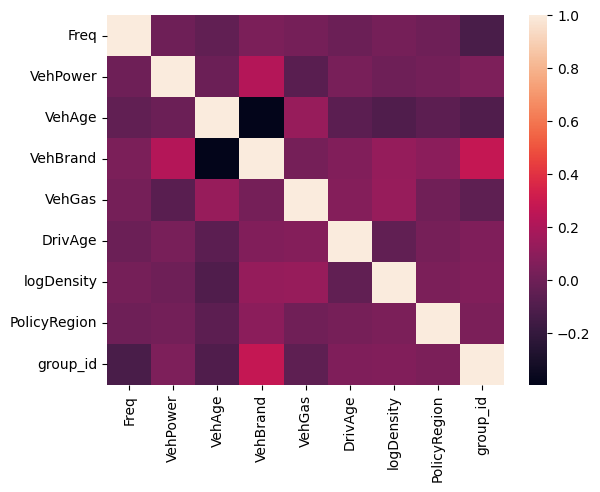

In [ ]:
#correlation
sns.heatmap(df.corr())
plt.savefig("corr_compare.png")

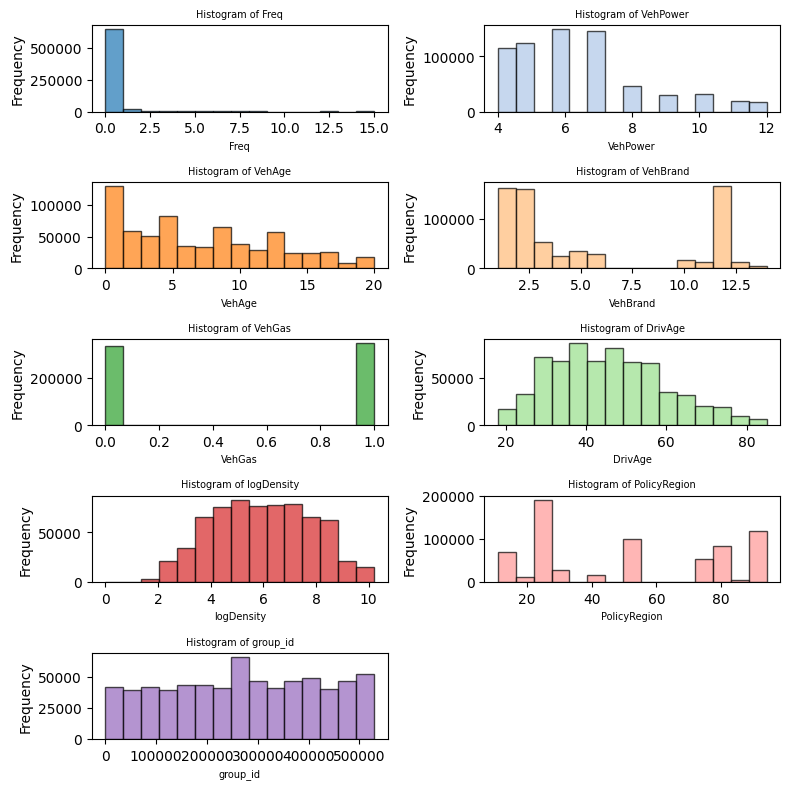

In [ ]:
# Number of histograms to display
num_histograms = 10

# Create a 4x4 grid of subplots to accommodate 16 histograms
num_rows = 5
num_cols = 2

# Create a figure and subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 8))

# Flatten the axes array to iterate through subplots easily
axes_flat = axes.flatten()

# Get a list of (16) distinct colors from the tab20 colormap
colors = plt.cm.tab20.colors[:num_histograms]

# Iterate through the DataFrame columns and plot histograms with distinct colors
for i, (column, ax) in enumerate(zip(df.columns, axes_flat)):
    df[column].plot.hist(ax=ax, bins=15, alpha=0.7, color=colors[i], edgecolor='black')
    ax.set_title(f'Histogram of {column}', fontsize = 7)
    ax.set_xlabel(column, fontsize = 7)

# Remove any extra empty subplots if the number of variables is less than 16
if i < num_histograms - 1:
    for j in range(i + 1, num_histograms):
        fig.delaxes(axes_flat[j])

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [ ]:
from google.colab import files
df.to_csv('frenchclaimV2.csv')
files.download('frenchclaimV2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>